## Behavior-Cloning

### Importing packages

In [1]:
### Import packages. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math

### Loading data

In [2]:
csv_path = '../data/driving_log.csv'
data_files= pd.read_csv(csv_path, header =None,
                         names=['center','left','right','steer','throttle','break'],
                        index_col = False)

In [3]:
#add a new column whose name is steer_sm with dtype of float32
steer_sm = np.array(data_files.steer,dtype=np.float32)

data_files['steer_sm'] = pd.Series(steer_sm, index=data_files.index)

In [4]:
data_files.head()

center  \
0  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   
1  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   
2  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   
3  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   
4  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   

                                                left  \
0   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   
1   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   
2   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   
3   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   
4   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   

                                               right  steer  throttle  break  \
0   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...    0.0       0.0    0.0   
1   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...    0.0       0.0    0.0   
2   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...    0.0       0.0    0.0   
3   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...    0.0       0.0    0.0   
4   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...    0.0       0.0    0.0   

   steer_sm  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [5]:
### explore the data to see the steer angle distribution

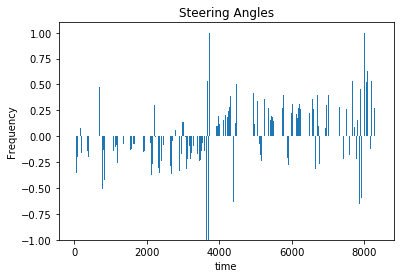

In [6]:
val = np.asarray((data_files['steer']))
count = range(len(data_files['steer']))

plt.bar(count, val,2)   # parameter '2' is the width of the bar
plt.title('Steering Angles')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.show()

#### Removing data with throttle(油门 ) below .25

In [7]:
len(data_files)

8400

In [8]:
ind = data_files['throttle']>.25
data_files= data_files[ind].reset_index()

In [9]:
len(data_files)

8282

In [10]:
#read img, convert from BGR 2 RGB and then perform normalization
def process_newimage_file(name,preprocess=0):
    image = cv2.imread(name)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    if preprocess==1:
        image = image/255.-.5   
    return image

### Data Augmentation 1: Including Left and Right camera. 
* The correction parameter is set to 0.25 and the default value is 0.2.

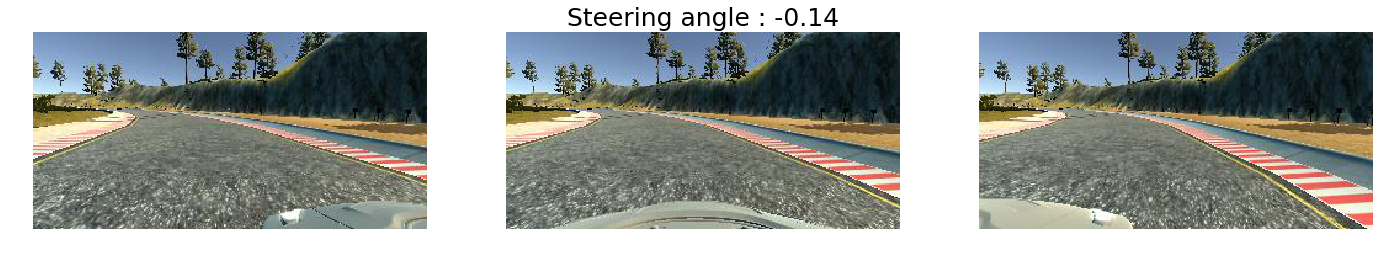

In [12]:
ind_num = 19   #choose the image of index number 19 to show

image_c = process_newimage_file(data_files['center'][ind_num].strip(),1)
image_r = process_newimage_file(data_files['right'][ind_num].strip(),1)
image_l = process_newimage_file(data_files['left'][ind_num].strip(),1)
plt.figure(figsize=(24,12))
plt.subplot(1,3,1)
plt.imshow(image_l+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c+.5);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(steer_sm[ind_num],2) ),fontsize=25);
plt.subplot(1,3,3)
plt.imshow(image_r+.5);
plt.axis('off');


In [13]:
print (np.round(0.25*180/np.pi,2))  #这边是弧度制转化为角度制,0.25弧度=14.32度,0.1弧度=5.73度
np.round((0+.1)*180/np.pi,2)

14.32


5.7300000000000004

In [16]:
# plot three cameras' images including center,right and left cameras
# 测试下来，左右2个镜头基于中间的camera各加减0.25个radian,最好！！！
# deg==1 means using degree to show the steer angel, while deg=0 means the radian.
def plot_camera_images(data,steer_sm,ind_num,deg = 0):
    image_l = process_newimage_file(data['left'][ind_num].strip(),1)
    image_c = process_newimage_file(data['center'][ind_num].strip(),1)
    image_r = process_newimage_file(data['right'][ind_num].strip(),1)
    
    #plt.figure(figsize=(24,12))
    plt.subplot(1,3,1)
    plt.imshow(image_l+.5);
    plt.axis('off')
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]+.25,2) )+' index:'+str(ind_num));
    else:
        plt.title('Steer:'+ str((np.round((steer_sm[ind_num]+.25)*180/np.pi,2) )))
    plt.subplot(1,3,2)
    plt.imshow(image_c+.5);
    plt.axis('off')
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num],2) ));
    else:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]*180/np.pi,2) ));
    plt.subplot(1,3,3)
    plt.imshow(image_r+.5);
    plt.axis('off');
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]-.25,2) ));
    else:
        plt.title('Steer:'+ str((np.round((steer_sm[ind_num]-.25)*180/np.pi,2) )))

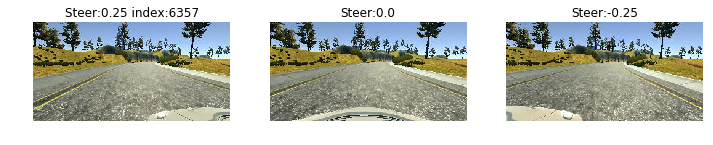

In [19]:
#test the plot_camera_images function
plt.figure(figsize=(12,18))
plot_camera_images(data_files,steer_sm,6357,0)

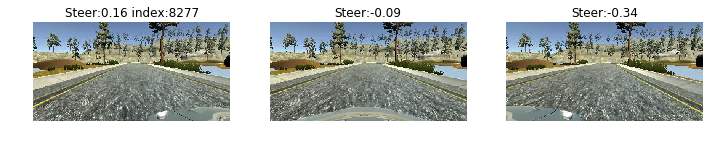

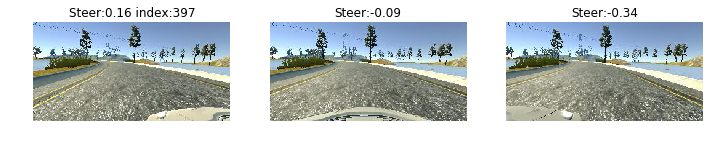

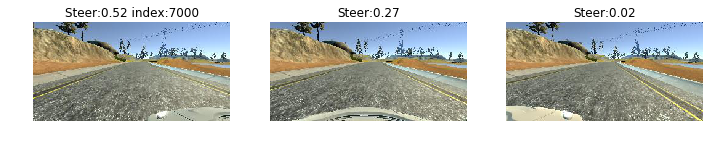

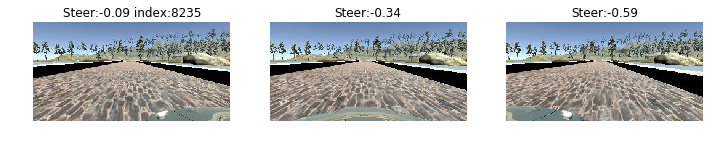

[8277, 397, 7000, 8235]


In [20]:
# randomly pick up 4 unzero imgs and using the plot camera funtion
ind_num=[]
i=0
while i<4:
    i_random = np.random.randint(len(data_files)-1)  #随机选择index
    if steer_sm[i_random]!=0.:     #如果steer angle !=0 则继续
        ind_num.append(i_random)
        i+=1
        plt.figure(figsize=(12,18))
        plot_camera_images(data_files,steer_sm,i_random,0)
        plt.show()
print (ind_num)

### Data Augmentation 2: Brightness shifting

In [21]:
#augment the brightness of an image   , rnd_high别设置太高，不然图片发黑
def augment_brightness_camera_images(image,rnd_low=0.75,rnd_high=1.25):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)     #转换成HSV color space,并修改value亮度
    #random_bright = .25+np.random.uniform()     #0.25+(0,1)范围内的随机数,结果为(0.25,1.25)
    #random_bright = .5+np.random.uniform()     #也可以设置成0.5，使得变亮和变暗的概率相同(0.5,1.5)
    random_bright = np.random.uniform(rnd_low,rnd_high)
    image1[:,:,2] = image1[:,:,2]*random_bright     #将原先的HSV中的V，随机变换成0.75倍数-1.25倍
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1,random_bright       

In [22]:
# test the augment_brightness function and set the random range of the brightness change
def plot_augment_brightness(data,idx,rnd_low=0.75,rnd_high=1.25):
    image= process_newimage_file(data['center'][idx].strip())
    plt.figure(figsize=(16,8))
    for i in range(16):
        image1,random_bright  = augment_brightness_camera_images(image,rnd_low,rnd_high)
        plt.subplot(4,4,i+1)
        plt.imshow(image1)
        plt.title(round(random_bright,2) )
        plt.axis('off')

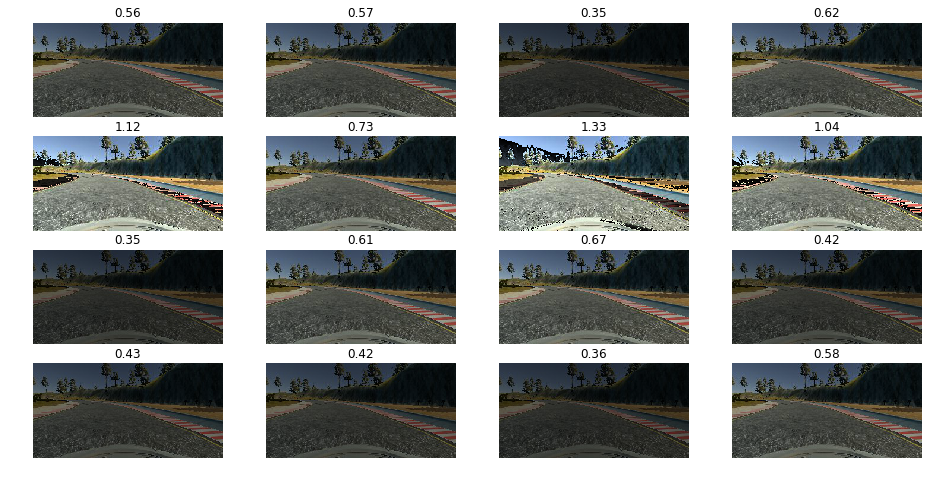

In [23]:
plot_augment_brightness(data_files,19,.25,1.35)

### Data Augmentation 3: translation image 

In [77]:
#choose an image that the steer angle is not zero
data_files[data_files['index']==397]

index                                             center  \
387    397  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   

                                                  left  \
387   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   

                                                 right     steer  throttle  \
387   /data/udacity/P3-Car-ND/P3-behavior-cloning/d... -0.094578       1.0   

     break  steer_sm  
387    0.0 -0.094578

In [78]:
steer_sm[397]

-0.094578274

In [79]:
image = cv2.imread(data_files['center'][387].strip())
steer = data_files['steer_sm'][387]
image_l = cv2.imread(data_files['left'][387].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)

(-0.5, 319.5, 159.5, -0.5)

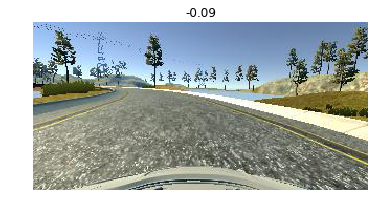

In [80]:
plt.imshow(image)
plt.title(round(steer,2))
plt.axis('off')

In [110]:
#这个函数中steer_ang中的默认角度增加的部分 是根据经验值来判断的，不准确！！！详见下边特斯拉例子的link
#https://zhuanlan.zhihu.com/p/25334400
def trans_image(image,steer,trans_range):   
   
    tr_x = trans_range*np.random.uniform()-trans_range/2  #randomly translate the img along x
    steer_ang = steer + tr_x/trans_range*2*.2      #使用经验值来定义x轴角度的变化
    tr_y = 10*np.random.uniform()-10/2             #randomly translate the img along axis y
   
    rows,cols,channels = image.shape
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])           #define the translation matrix
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))    #create the new translated image
    
    return image_tr,steer_ang,tr_x

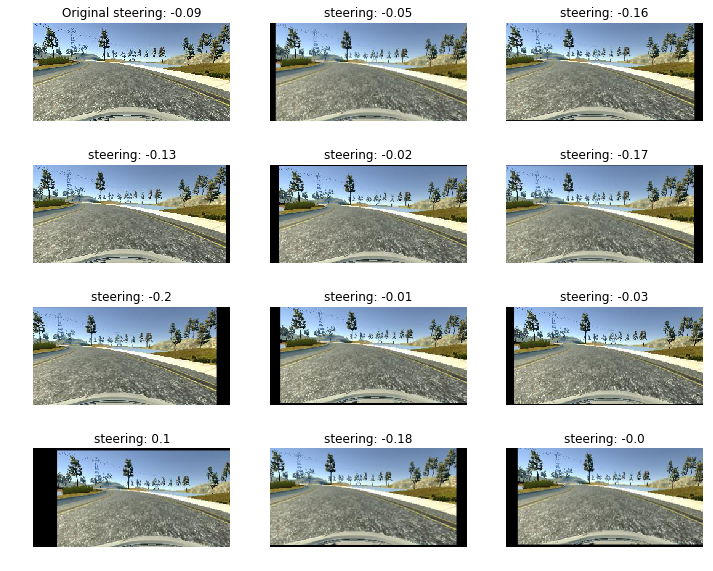

In [116]:
#plot the original image and the randomly translated images
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('Original steering: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x = trans_image(image,steer,80)
    plt.title('steering: ' + str(np.round(steer_ang,2)) )
    plt.imshow(image_tr)
    plt.axis('off');

#### steer_ang = steer + tr_x/trans_range*2*.2等式中tr_x/trans_range*2*.2经验值的由来

In [104]:
#当tr_x即为x轴移动的像素，最大时为40，此时对应的steer增加的弧度为0.2；最小值为-40,steer增加值为-0.2
40/80*2*0.2

0.2

In [105]:
0.2/40       #由此可得，每次移动1个像素，对应steer要增加0.005弧度

0.005

In [107]:
image.shape

(160, 320, 3)

In [108]:
0.001309*4

0.005236

### Data Augmentation 4: Flipping images

(-0.5, 319.5, 159.5, -0.5)

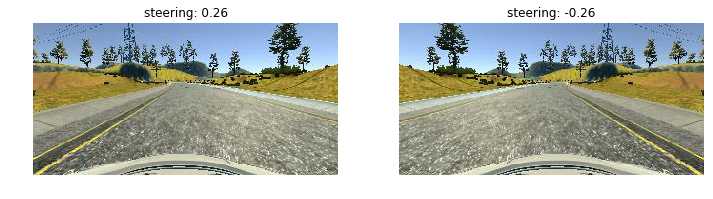

In [117]:
#flip function test
image = cv2.imread(data_files['center'][2253].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
steer_ang=  data_files['steer_sm'][2253]
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('steering: ' + str(np.round(steer_ang,2)) )
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
image_conv = cv2.flip(image,1)
plt.title('steering: ' + str(np.round(-steer_ang,2)) )
plt.imshow(image_conv)
plt.axis('off')

### Preprocess: crop and resize the image

(160, 320, 3)

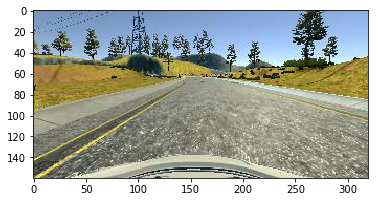

In [150]:
#x是纵轴，Y是横轴
plt.imshow(image)
image.shape

In [151]:
new_size_col = 64
new_size_row = 64

#crop the image to get rid of useless parts of images like sky and car body
#also, this function resize the image to 64x64
def preprocessImage(image,resize=1):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    #参看上图,y范围(160/4=40,160-25), x的范围不变
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]] 
    if resize==1: 
        image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
        #image = image/255.-.5
    return image 

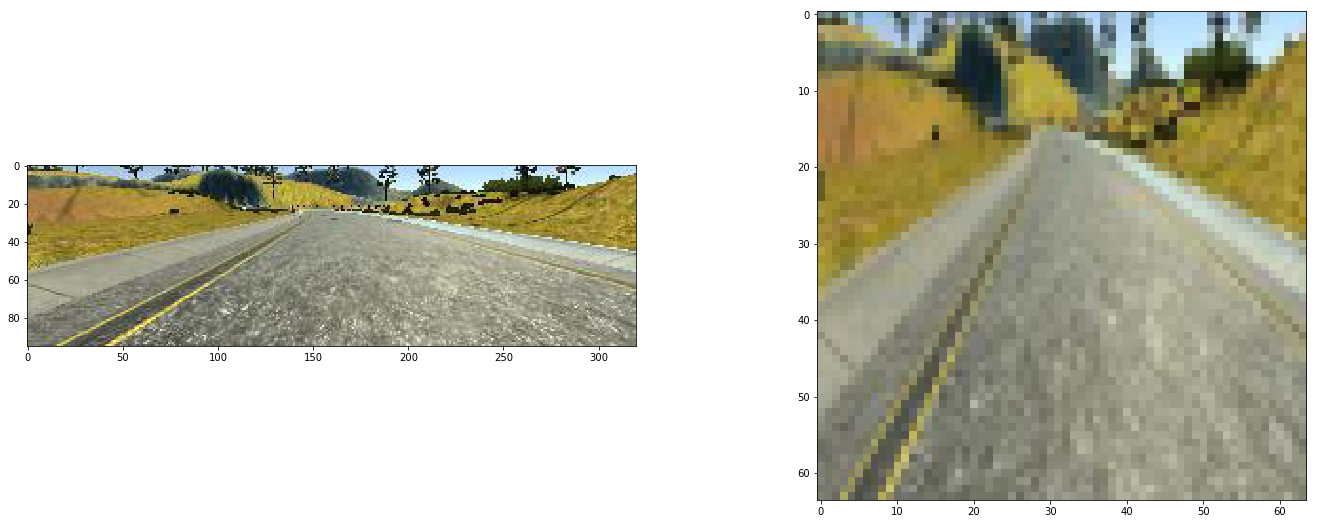

In [152]:
#test the preprocessImage function
crop_img=preprocessImage(image,resize=0)
crop_resize=preprocessImage(image,resize=1)
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.imshow(crop_img)
plt.subplot(1,2,2)
plt.imshow(crop_resize)

### combine all the preprocess and augmentation functions

In [153]:
#assemble all the augmentation function
#输入一个图片的路径，随机选择3个camera中的一张图片，
#然后trans_image,brightness,preprocess(crop,resize), randomly flip
def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
    y_steer = line_data['steer_sm'][0] + shift_ang
    image = cv2.imread(path_file)
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer,tr_x = trans_image(image,y_steer,150)
    image,random_bright = augment_brightness_camera_images(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

def preprocess_image_file_predict(line_data):
    path_file = line_data['center'][0].strip()
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = preprocessImage(image)
    image = np.array(image)
    return image

In [154]:
# test preprocess_image_file_train function

In [155]:
data_files.iloc[[2253]].reset_index()

level_0  index                                             center  \
0     2253   2263  /data/udacity/P3-Car-ND/P3-behavior-cloning/da...   

                                                left  \
0   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...   

                                               right     steer  throttle  \
0   /data/udacity/P3-Car-ND/P3-behavior-cloning/d...  0.257556       1.0   

   break  steer_sm  
0    0.0  0.257556

In [156]:
line_data = data_files.iloc[[2253]].reset_index()

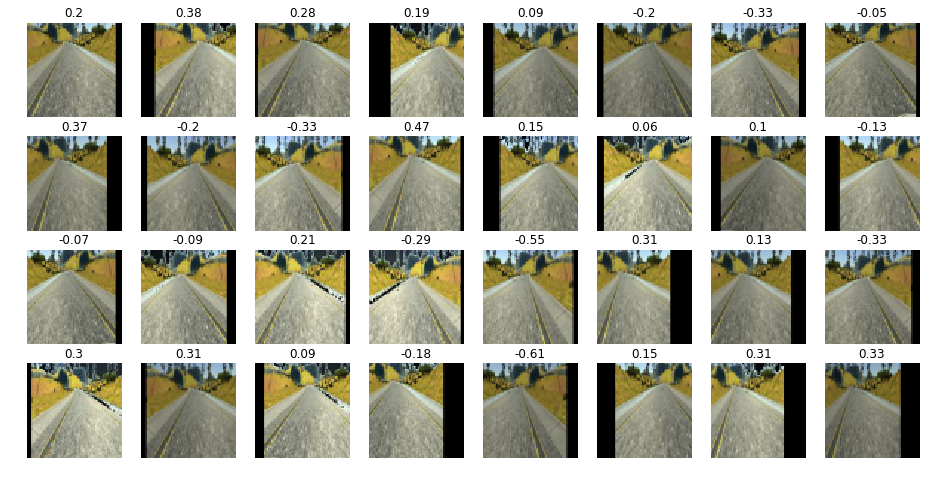

In [157]:
plt.figure(figsize=(16,8))
for i in range(32):
    image,steer = preprocess_image_file_train(line_data)

    plt.subplot(4,8,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))

### Keras generator

In [30]:
pr_threshold = 1

def generate_train_from_PD_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

In [31]:
def generate_train_from_PD(data):
    while 1:
        i_line = np.random.randint(len(data))
        line_data = data.iloc[[i_line]].reset_index()
        x,y = preprocess_image_file_train(line_data)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        y = np.array([[y]])
        yield x, y

def generate_valid_from_PD(data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer_sm'][0]
            y = np.array([[y]])
            yield x, y

        
valid_s_generator = generate_valid_from_PD(data_files)

### Model architecture

In [32]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations

Using TensorFlow backend.


#### Nvidia paper model

In [33]:
import tensorflow as tf
tf.python.control_flow_ops = tf
new_size_row = 64
new_size_col = 64

input_shape = (new_size_row, new_size_col, 3)
model = Sequential()
model.add(Lambda(lambda x:x/255.-0.5, input_shape=input_shape))
model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")


### Training


I trained the model using the keras generator with batch size of 128 for 100 epochs. In each epoch, I generated 30000 images. 

In [34]:
from pathlib import Path
import json
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

In [36]:
val_size = len(data_files)    #8000
pr_threshold = 1

batch_size = 128     #256
num_examples_per_epoch = 30000  #20000
num_epoch = 100

i_best = 0
val_best = 1000




#for i_pr in range(10):
for i_pr in range(num_epoch):
    train_r_generator = generate_train_from_PD_batch(data_files,batch_size)

    nb_vals = np.round(len(data_files)/val_size)-1
    history = model.fit_generator(train_r_generator,
            samples_per_epoch=num_examples_per_epoch, nb_epoch=1,verbose=2,validation_data=valid_s_generator,
                        nb_val_samples=val_size)
    if history.history['loss'][0]<=0.5:   
        fileModelJSON = './models/model_' + str(i_pr) + '.json'
        fileWeights = './models/model_' + str(i_pr) + '.h5'
        save_model(fileModelJSON,fileWeights)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr 
        val_best = val_loss
        fileModelJSON = './models/model_best.json'
        fileWeights = './models/model_best.h5'
        save_model(fileModelJSON,fileWeights)
    
    
    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1


/home/patrick/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


231s - loss: 0.0601 - acc: 0.0000e+00 - val_loss: 0.0836 - val_acc: 0.7198
Epoch 1/1
164s - loss: 0.0431 - acc: 0.0000e+00 - val_loss: 0.0921 - val_acc: 0.7198
Epoch 1/1
123s - loss: 0.0393 - acc: 0.0000e+00 - val_loss: 0.1021 - val_acc: 0.7198
Epoch 1/1
114s - loss: 0.0377 - acc: 0.0000e+00 - val_loss: 0.0918 - val_acc: 0.7198
Epoch 1/1
110s - loss: 0.0363 - acc: 0.0000e+00 - val_loss: 0.0722 - val_acc: 0.7198
Epoch 1/1
109s - loss: 0.0353 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.7198
Epoch 1/1
109s - loss: 0.0342 - acc: 0.0000e+00 - val_loss: 0.0907 - val_acc: 0.7198
Epoch 1/1
107s - loss: 0.0341 - acc: 0.0000e+00 - val_loss: 0.0664 - val_acc: 0.7198
Epoch 1/1
107s - loss: 0.0329 - acc: 0.0000e+00 - val_loss: 0.0834 - val_acc: 0.7198
Epoch 1/1
106s - loss: 0.0332 - acc: 0.0000e+00 - val_loss: 0.0655 - val_acc: 0.7198
Epoch 1/1
107s - loss: 0.0326 - acc: 0.0000e+00 - val_loss: 0.0889 - val_acc: 0.7198
Epoch 1/1
105s - loss: 0.0323 - acc: 0.0000e+00 - val_loss: 0.0932 - val_ac